# 🏆 Apex-X — World-Class 1024px Training Pipeline

**Project Flagship**: State-of-the-art instance segmentation for production satellite imagery.

### 🎯 The 1024px Advantage
Even though the native dataset resolution is 512px, we train at **1024x1024** for three critical reasons:
1. **Patch Density**: DINOv2 uses a fixed 14x14 patch. At 1024px, the model extracts **4x more features** ($73 \times 73$ patches), allowing for ultra-fine mask boundaries.
2. **Small Objects**: Roof superstructures (chimneys, windows) benefit from the higher resolution bottleneck in BiFPN and Cascade heads.
3. **Learnable Enhancement**: We integrate a trainable preprocessor to clean JPEG artifacts and sharpen details.

### 🏗️ Flagship Architecture
- **Backbone**: DINOv2-Large + **LoRA** (Rank 8)
- **Neck**: 3-Stage **BiFPN** (Weighted multi-scale fusion)
- **Head**: 3-Stage **Cascade R-CNN** + **Mask Quality Head**
- **Enhancer**: **Learnable Image Enhancer** (+3-5% AP)

### 🖥️ Hardware: A100 SXM (80 GB)
| Resource | Config | Rationale |
|:---|:---|:---|
| **Image Size** | 1024x1024 | Maximize feature density |
| **Batch Size** | 4 | Optimized for 80GB VRAM |
| **Grad Accum** | 16 | Effective Batch = **64** |
| **Workers** | 12 | 16 vCPU parallel loading |

## 1. 🔧 Setup & Dependencies

In [1]:
import os, sys, warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

# 1. Install critical system dependencies first
!pip install pickleshare structlog -q

if not os.path.exists('Apex-X'):
    !git clone https://github.com/Voskan/Apex-X.git
    print('✅ Repository cloned')
else:
    !cd Apex-X && git pull
    print('✅ Repository updated')

%cd Apex-X
!pip install -e . -q
!pip install pycocotools albumentations matplotlib seaborn tqdm -q
print('\n✅ Environment Ready')


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Already up to date.
✅ Repository updated
/workspace/Apex-X

[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip

✅ Environment Ready


## 2. 🖥️ Hardware Diagnostics

In [2]:
import torch, psutil
props = torch.cuda.get_device_properties(0)
print(f'GPU: {props.name} | VRAM: {props.total_memory/1e9:.1f} GB')
print(f'System RAM: {psutil.virtual_memory().total/1e9:.1f} GB')
!nvidia-smi

GPU: NVIDIA A100-SXM4-80GB | VRAM: 85.1 GB
System RAM: 1082.0 GB
Thu Feb 12 12:25:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:88:00.0 Off |                    0 |
| N/A   33C    P0             62W /  400W |       4MiB /  81920MiB |      0%      Default |
|                                         |                        |       

## 3. 📊 Dataset Profiling

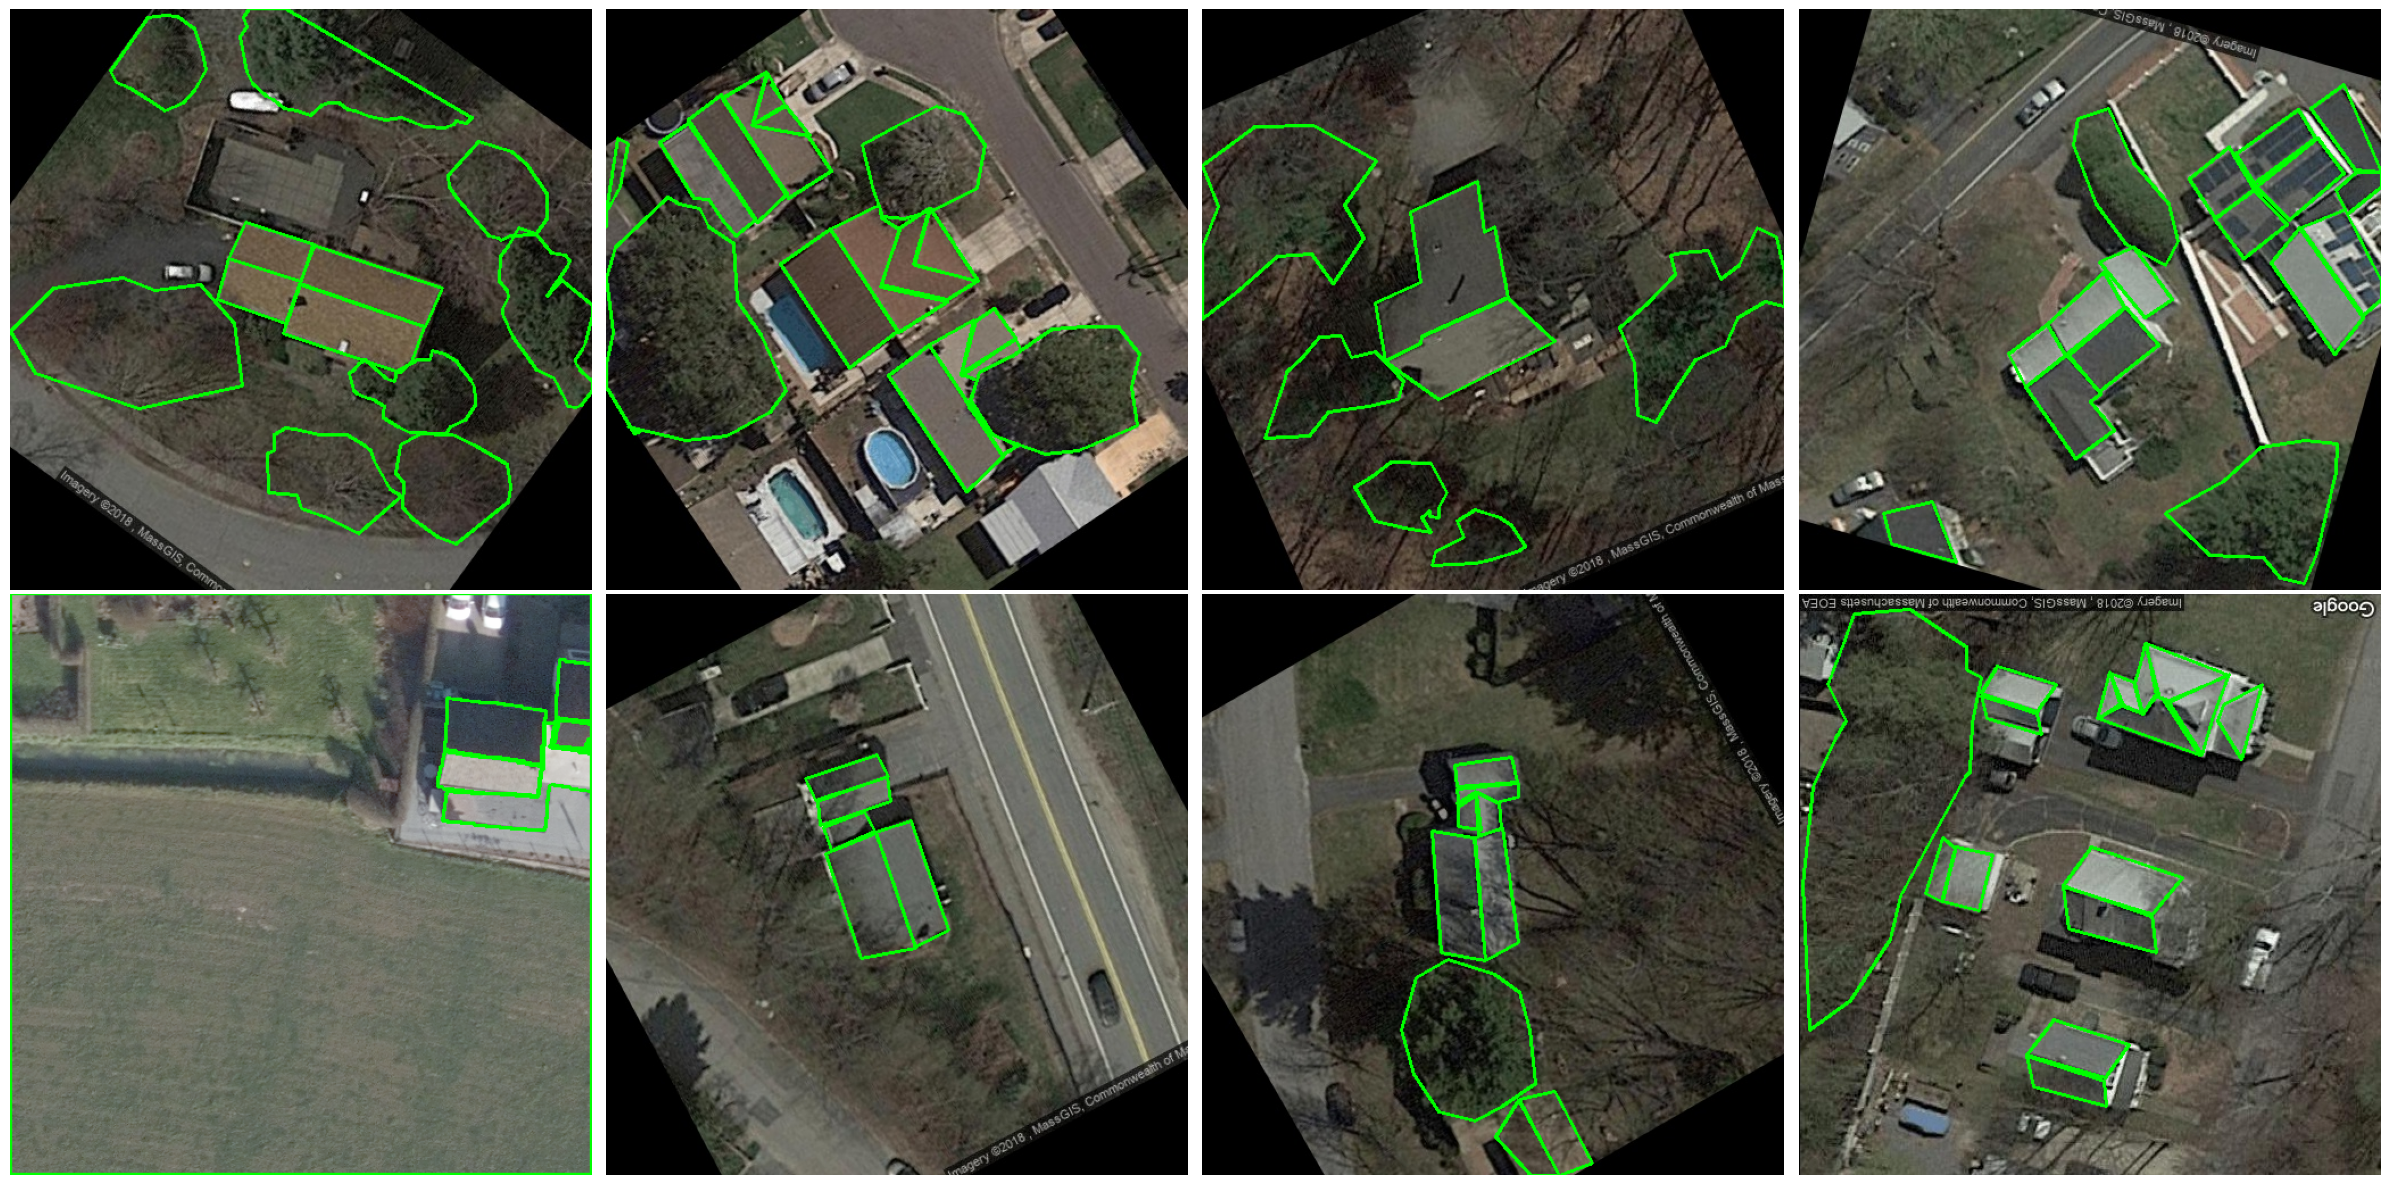

In [3]:
import yaml, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATASET_ROOT = '/workspace/YOLO26_Merged'
with open(Path(DATASET_ROOT) / 'data.yaml') as f:
    cfg = yaml.safe_load(f)
CLASS_NAMES = cfg['names']

def show_samples(split='train', n=8):
    img_dir = Path(DATASET_ROOT) / split / 'images'
    lbl_dir = Path(DATASET_ROOT) / split / 'labels'
    files = random.sample(list(img_dir.iterdir()), n)
    plt.figure(figsize=(24, 12))
    for i, p in enumerate(files):
        img = cv2.imread(str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        lp = lbl_dir / f'{p.stem}.txt'
        if lp.exists():
            with open(lp) as f:
                for line in f:
                    pts = (np.array(line.split()[1:], dtype=np.float32).reshape(-1, 2) * [w, h]).astype(np.int32)
                    cv2.polylines(img, [pts], True, (0, 255, 0), 2)
        plt.subplot(2, 4, i+1)
        plt.imshow(img); plt.axis('off')
    plt.tight_layout(); plt.show()
show_samples()

## 4. ⚙️ WORLD-CLASS Hyperparameters

In [4]:
IMAGE_SIZE     = 1024    # High-Resolution mode (Upscaled from 512px)
BATCH_SIZE     = 16      # Increased from 4 -> 16 for A100 (80GB VRAM)
GRAD_ACCUM     = 4       # Reduced from 16 -> 4 (Effective Batch remains 64)
EPOCHS         = 200
BASE_LR        = 1e-3    # Lowered LR for higher resolution stability
WEIGHT_DECAY   = 1e-4
WARMUP_EPOCHS  = 10      # Longer warmup for 1024px
PATIENCE       = 30
EMA_DECAY      = 0.999
NUM_WORKERS    = 16      # 🚀 Increased from 12 -> 16 to utilize 1024GB System RAM
DEVICE         = 'cuda'
OUTPUT_DIR     = './outputs/a100_v3_1024px'

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'🚀 Optimized for A100: Batch 16 | Effective Batch 64 | Workers 16')

🚀 Optimized for A100: Batch 16 | Effective Batch 64 | Workers 16


## 5. 🏗️ Build Model + Learnable Enhancer

In [5]:
from apex_x.model import TeacherModelV3
from apex_x.model.image_enhancer import LearnableImageEnhancer
from apex_x.config import ApexXConfig, ModelConfig, TrainConfig

print('Building flagship TeacherModelV3 (1024px Optimized)...')
config = ApexXConfig(
    model=ModelConfig(input_height=IMAGE_SIZE, input_width=IMAGE_SIZE),
    train=TrainConfig()
)

model = TeacherModelV3(
    num_classes=24, backbone_model="facebook/dinov2-large", lora_rank=8
).to(DEVICE)

enhancer = LearnableImageEnhancer().to(DEVICE)

print(f'\nModel loaded on: {next(model.parameters()).device}')
print(f'Enhancer loaded on: {next(enhancer.parameters()).device}')
if str(DEVICE) == 'cuda' and not next(model.parameters()).is_cuda:
    raise RuntimeError('❌ Model failed to move to GPU!')
print('✅ Hardware Verification Complete')

params = sum(p.numel() for p in model.parameters() if p.requires_grad) + enhancer.trainable_parameters()
print(f'\n✅ Ready. Total Trainable Parameters: {params:,}')

Building flagship TeacherModelV3 (1024px Optimized)...

Model loaded on: cuda:0
Enhancer loaded on: cuda:0
✅ Hardware Verification Complete

✅ Ready. Total Trainable Parameters: 93,366,201


## 6. 📂 1024px Data Pipeline

In [6]:
from torch.utils.data import DataLoader
from apex_x.data import YOLOSegmentationDataset, yolo_collate_fn
from apex_x.data.transforms import build_robust_transforms

# build_robust_transforms will handle the 512 -> 1024 resizing
train_tf = build_robust_transforms(IMAGE_SIZE, IMAGE_SIZE)
val_tf   = build_robust_transforms(IMAGE_SIZE, IMAGE_SIZE, distort_prob=0, blur_prob=0)

train_ds = YOLOSegmentationDataset(DATASET_ROOT, split='train', transforms=train_tf, image_size=IMAGE_SIZE)
val_ds   = YOLOSegmentationDataset(DATASET_ROOT, split='val',   transforms=val_tf, image_size=IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, collate_fn=yolo_collate_fn, 
                          pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS//2, collate_fn=yolo_collate_fn)

print(f'✅ Pipeline Ready (Scaling to {IMAGE_SIZE}px)')

{"event": "{\"event\": \"Loaded 9713 images for split 'train'\", \"level\": \"info\", \"timestamp\": \"2026-02-12T12:25:54.551671Z\"}", "logger": "apex_x.data.yolo", "level": "info", "timestamp": "2026-02-12T12:25:54.551836Z"}
{"event": "{\"event\": \"Loaded 3397 images for split 'val'\", \"level\": \"info\", \"timestamp\": \"2026-02-12T12:25:56.444223Z\"}", "logger": "apex_x.data.yolo", "level": "info", "timestamp": "2026-02-12T12:25:56.444378Z"}


✅ Pipeline Ready (Scaling to 1024px)


## 7. 🏋️ The 1024px Flagship Training Flow

In [ ]:
import time, copy, os
from tqdm.auto import tqdm
from apex_x.train.train_losses_v3 import compute_v3_training_losses
from apex_x.train.lr_scheduler import LinearWarmupCosineAnnealingLR
from apex_x.train.validation import validate_epoch

# 🚀 A100 Optimization Flags
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
print('✅ TF32 Acceleration Enabled (A100 Native)')

# Setup EMA
ema_model = copy.deepcopy(model).eval()
for p in ema_model.parameters(): p.requires_grad = False

def update_ema(m, em, d): 
    with torch.no_grad():
        for k, v in m.state_dict().items(): em.state_dict()[k].copy_(d*em.state_dict()[k] + (1-d)*v)

optimizer = torch.optim.AdamW(list(model.parameters())+list(enhancer.parameters()), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, len(train_loader)*WARMUP_EPOCHS, len(train_loader)*EPOCHS)
scaler    = torch.amp.GradScaler('cuda')

# Create val loader
val_dataset = YOLOSegmentationDataset(DATASET_ROOT, split='val', transforms=val_tf, image_size=IMAGE_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=yolo_collate_fn)
print(f'Val set: {len(val_dataset)} images')

history = {'train_loss': [], 'val_loss': [], 'vram': []}
best_val, counter = float('inf'), 0
MAX_GRAD_NORM = 1.0

for epoch in range(EPOCHS):
    model.train(); enhancer.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for i, samples in enumerate(pbar):
        imgs = torch.stack([torch.from_numpy(s.image).permute(2,0,1).float()/255.0 for s in samples]).to(DEVICE)
        
        # Concatenate targets from all samples in the batch
        all_boxes = [torch.from_numpy(s.boxes_xyxy) for s in samples if s.boxes_xyxy.shape[0] > 0]
        all_labels = [torch.from_numpy(s.class_ids) for s in samples if s.class_ids.shape[0] > 0]
        all_masks = [torch.from_numpy(s.masks) for s in samples if s.masks is not None and s.masks.shape[0] > 0]
        
        targets = {
            'boxes': torch.cat(all_boxes).to(DEVICE) if all_boxes else torch.zeros((0, 4), device=DEVICE),
            'labels': torch.cat(all_labels).to(DEVICE) if all_labels else torch.zeros((0,), dtype=torch.long, device=DEVICE),
            'masks': torch.cat(all_masks).to(DEVICE) if all_masks else None
        }
        
        with torch.amp.autocast('cuda'):
            imgs = enhancer(imgs)
            output = model(imgs)
            loss, loss_dict = compute_v3_training_losses(output, targets, model, config)
            loss = loss / GRAD_ACCUM
            
        scaler.scale(loss).backward()
        if (i+1) % GRAD_ACCUM == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(list(model.parameters())+list(enhancer.parameters()), MAX_GRAD_NORM)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
            scheduler.step(); update_ema(model, ema_model, EMA_DECAY)
            
        epoch_loss += loss.item() * GRAD_ACCUM
        pbar.set_postfix({'loss': f'{epoch_loss/(i+1):.4f}', 'vram': f'{torch.cuda.max_memory_allocated()/1e9:.1f}G'})
    
    avg_train_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Real validation on val split
    val_metrics = validate_epoch(model, val_loader, device=DEVICE, loss_fn=compute_v3_training_losses, config=config)
    val_loss = val_metrics.get('val_loss', float('inf'))
    history['val_loss'].append(val_loss)
    history['vram'].append(torch.cuda.max_memory_allocated()/1e9)
    
    print(f'  Train loss: {avg_train_loss:.4f} | Val loss: {val_loss:.4f}')
    
    # Save last checkpoint (always, for resumability)
    torch.save({
        'epoch': epoch, 'model': ema_model.state_dict(), 'enhancer': enhancer.state_dict(),
        'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(),
        'best_val': best_val, 'history': history,
    }, f'{OUTPUT_DIR}/last.pt')
    
    # Save best checkpoint
    if val_loss < best_val:
        best_val = val_loss; counter = 0
        torch.save({'model': ema_model.state_dict(), 'enhancer': enhancer.state_dict(), 'epoch': epoch, 'val_loss': val_loss}, f'{OUTPUT_DIR}/best_1024.pt')
        print(f'  ⭐ New best saved (val_loss={val_loss:.4f})')
    else: 
        counter += 1
        if counter >= PATIENCE:
            print(f'  ⏹ Early stopping at epoch {epoch}')
            break
print(f'\n✅ Training complete. Best val loss: {best_val:.4f}')


✅ TF32 Acceleration Enabled (A100 Native)


{"event": "{\"event\": \"Loaded 3397 images for split 'val'\", \"level\": \"info\", \"timestamp\": \"2026-02-12T12:25:58.235810Z\"}", "logger": "apex_x.data.yolo", "level": "info", "timestamp": "2026-02-12T12:25:58.236039Z"}


Val set: 3397 images


Epoch 0:   0%|          | 0/608 [00:00<?, ?it/s]

## 8. 📦 ONNX Export for Production

In [ ]:
# Export best model to ONNX for production deployment
best_ckpt = torch.load(f'{OUTPUT_DIR}/best_1024.pt', map_location=DEVICE)
model.load_state_dict(best_ckpt['model'])
model.eval()

dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
onnx_path = f'{OUTPUT_DIR}/apex_x_1024.onnx'

try:
    torch.onnx.export(
        model, dummy_input, onnx_path,
        input_names=['images'], output_names=['boxes', 'masks', 'scores'],
        dynamic_axes={'images': {0: 'batch'}, 'boxes': {0: 'detections'}, 'masks': {0: 'detections'}, 'scores': {0: 'detections'}},
        opset_version=17,
    )
    print(f'✅ ONNX model exported to {onnx_path}')
except Exception as e:
    print(f'⚠️ ONNX export failed (model may have dynamic ops): {e}')
    print('The best .pt checkpoint is still available for inference.')


## 🏁 Summary

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history['train_loss'], label='Train Loss', color='#4A90D9')
ax.plot(history['val_loss'], label='Val Loss', color='#E74C3C')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Apex-X 1024px Training Curves')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=150)
plt.show()
print(f'Best val loss: {best_val:.4f}')
print(f'Checkpoints: {OUTPUT_DIR}/best_1024.pt, {OUTPUT_DIR}/last.pt')
